In [ ]:
import pandas as pd
import sqlite3
from sqlite3 import Error
import requests  # For fetching API data
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import warnings
import os # To check for file

# Suppress warnings
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn')
warnings.filterwarnings('ignore', category=FutureWarning)

print("--- Libraries Imported Successfully ---")

--- Libraries Imported Successfully ---


In [ ]:
# --- E: EXTRACT (Source 1: CSV) ---

csv_file_name = 'ecommerce_sales_34500.csv'
if not os.path.exists(csv_file_name):
    print(f"[ETL Extract] ERROR: File '{csv_file_name}' not found.")
    df_sales_source = pd.DataFrame()
else:
    try:
        df_sales_source = pd.read_csv(csv_file_name)
        print(f"[ETL Extract] Successfully read '{csv_file_name}'.")
        print(f"  - Sales source data has {len(df_sales_source)} rows.")
    except Exception as e:
        print(f"An error occurred: {e}")
        df_sales_source = pd.DataFrame()

# --- E: EXTRACT (Source 2: API) ---

api_url = "https://dummyjson.com/products?limit=100"
print(f"\n[ETL Extract] Fetching data from API: {api_url}...")
try:
    response = requests.get(api_url)
    response.raise_for_status()
    api_data = response.json()
    product_list = api_data['products']
    df_api_source = pd.DataFrame(product_list)
    print(f"  - API data fetched successfully. Received {len(df_api_source)} products.")
except requests.exceptions.RequestException as e:
    print(f"Error fetching API data: {e}")
    df_api_source = pd.DataFrame()

[ETL Extract] Successfully read 'ecommerce_sales_34500.csv'.
  - Sales source data has 34500 rows.

[ETL Extract] Fetching data from API: https://dummyjson.com/products?limit=100...
  - API data fetched successfully. Received 100 products.


In [ ]:
# --- T: TRANSFORM (Data Mart 1: Sales from CSV) ---

if not df_sales_source.empty:
    print("[ETL Transform] Building 'Sales Data Mart' (from CSV)...")

    # 1. Clean Sales Data (Fulfills Data Quality objective)
    df_sales_source.drop_duplicates(inplace=True)
    # Handle missing values, e.g., fill 0 for discount
    df_sales_source['discount'].fillna(0, inplace=True)
    df_sales_source['order_date'] = pd.to_datetime(df_sales_source['order_date'])
    df_sales_source.dropna(subset=['customer_id', 'product_id'], inplace=True)
    print("  - Sales data cleaned (duplicates dropped, dates converted).")

    # 2. Create DimCustomer
    dim_customer = df_sales_source[['customer_id', 'customer_age', 'customer_gender']].drop_duplicates()
    dim_customer.rename_axis('CustomerKey', axis='index', inplace=True)
    dim_customer.reset_index(inplace=True)
    dim_customer['CustomerKey'] += 1 # Start keys from 1
    print(f"  - DimCustomer created with {len(dim_customer)} customers.")

    # 3. Create DimProduct_Sales (from the CSV's product info)
    dim_product_sales = df_sales_source[['product_id', 'category']].drop_duplicates()
    dim_product_sales.rename_axis('ProductKey', axis='index', inplace=True)
    dim_product_sales.reset_index(inplace=True)
    dim_product_sales['ProductKey'] += 1
    print(f"  - DimProduct_Sales created with {len(dim_product_sales)} products.")

    # 4. Create DimDate
    unique_dates = df_sales_source['order_date'].dt.date.unique()
    dim_date = pd.DataFrame({'Date': pd.to_datetime(unique_dates)})
    dim_date['DateKey'] = dim_date['Date'].dt.strftime('%Y%m%d').astype(int)
    dim_date['Month'] = dim_date['Date'].dt.month
    dim_date['Year'] = dim_date['Date'].dt.year
    dim_date['Quarter'] = dim_date['Date'].dt.quarter
    print(f"  - DimDate created with {len(dim_date)} unique dates.")
else:
    print("[ETL Transform] Skipping Sales Mart: Sales source data is empty.")

[ETL Transform] Building 'Sales Data Mart' (from CSV)...
  - Sales data cleaned (duplicates dropped, dates converted).
  - DimCustomer created with 33877 customers.
  - DimProduct_Sales created with 32843 products.
  - DimDate created with 731 unique dates.


In [ ]:
# --- T: TRANSFORM (Data Mart 1: FactSales) ---

if not df_sales_source.empty:
    print("[ETL Transform] Building FactSales table...")

    # Ensure the date format is consistent for merging
    df_sales_source['order_date_only'] = pd.to_datetime(df_sales_source['order_date'].dt.date)

    # Merge with dimensions to get the new surrogate keys
    fact_sales = df_sales_source.merge(
        dim_customer, on='customer_id'
    ).merge(
        dim_product_sales, on=['product_id', 'category']
    ).merge(
        dim_date, left_on='order_date_only', right_on='Date'
    )

    # Select only the keys and measures for the fact table
    fact_sales = fact_sales[[
        'order_id',
        'DateKey',
        'CustomerKey',
        'ProductKey',
        'price',
        'discount',
        'quantity',
        'payment_method',
        'total_amount',
        'shipping_cost',
        'profit_margin',
        'region',
        'returned'
    ]]

    # Drop the temporary date column
    df_sales_source.drop(columns=['order_date_only'], inplace=True)


    print(f"  - FactSales created with {len(fact_sales)} rows.")
    print("\n--- FactSales Sample ---")
    print(fact_sales.head())
else:
    print("[ETL Transform] Skipping FactSales: Sales source data is empty.")

[ETL Transform] Building FactSales table...
  - FactSales created with 179716 rows.

--- FactSales Sample ---
  order_id   DateKey  CustomerKey  ProductKey   price  discount  quantity  \
0  O100000  20231223            1           1  164.08      0.15         1   
1  O100000  20231223        11086           1  164.08      0.15         1   
2  O100000  20231223        13834           1  164.08      0.15         1   
3  O100000  20231223        25660           1  164.08      0.15         1   
4  O100001  20250403            2           2   24.73      0.00         1   

  payment_method  total_amount  shipping_cost  profit_margin region returned  
0    Credit Card        139.47           7.88          31.17   West       No  
1    Credit Card        139.47           7.88          31.17   West       No  
2    Credit Card        139.47           7.88          31.17   West       No  
3    Credit Card        139.47           7.88          31.17   West       No  
4    Credit Card         24.73  

In [ ]:
fact_sales.to_csv('fact_sales.csv', index=False)

**Load in Aiven Db**

In [ ]:
from sqlalchemy import create_engine

# Aiven connection info
username = "avnadmin"
password = "AVNS_2qfKxYCuW4yvo49vzm8"
host = "pg-29b815f1-khuzaimahassan52-cd49.i.aivencloud.com"
port = 27193
database = "defaultdb"

engine = create_engine(
    f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}?sslmode=require"
)

In [ ]:

dim_customer.to_sql('dim_customers', engine, if_exists='replace', index=False)
print("dim_customers loaded successfully")

dim_date.to_sql('dim_dates', engine, if_exists='replace', index=False)
print("dim_dates loaded successfully")

dim_product_sales.to_sql('dim_product_sales', engine, if_exists='replace', index=False)
print("dim_regions loaded successfully")

fact_sales.to_sql('fact_sales', engine, if_exists='replace', index=False)
print("fact_sales loaded successfully")


dim_customers loaded successfully
dim_dates loaded successfully
dim_regions loaded successfully
fact_sales loaded successfully


In [ ]:
# --- T: TRANSFORM (Data Mart 2: Product Inventory from API) ---

if not df_api_source.empty:
    print("\n[ETL Transform] Building 'Product Data Mart' (from API)...")

    # 1. Create DimCategory_API
    unique_categories = df_api_source['category'].unique()
    dim_category_api = pd.DataFrame(unique_categories, columns=['CategoryName'])
    dim_category_api.rename_axis('CategoryKey', axis='index', inplace=True)
    dim_category_api.reset_index(inplace=True)
    dim_category_api['CategoryKey'] += 1
    print(f"  - DimCategory_API created with {len(dim_category_api)} categories.")

    # 2. Create DimProduct_API
    dim_product_api = df_api_source[['id', 'title', 'brand', 'category']].copy()
    dim_product_api.rename(columns={'id': 'ProductKey_API', 'title': 'ProductName'}, inplace=True)
    print(f"  - DimProduct_API created with {len(dim_product_api)} products.")

    # 3. Create FactProductStats
    fact_product_stats = df_api_source.merge(
        dim_category_api, left_on='category', right_on='CategoryName'
    )

    fact_product_stats = fact_product_stats[[
        'id', 'CategoryKey', 'price', 'discountPercentage', 'rating', 'stock'
    ]]
    fact_product_stats.rename(columns={'id': 'ProductKey_API'}, inplace=True)

    print(f"  - FactProductStats created with {len(fact_product_stats)} rows.")
    print("\n--- FactProductStats Sample ---")
    print(fact_product_stats.head())
else:
    print("[ETL Transform] Skipping Product Mart: API source data is empty.")



[ETL Transform] Building 'Product Data Mart' (from API)...
  - DimCategory_API created with 11 categories.
  - DimProduct_API created with 100 products.
  - FactProductStats created with 100 rows.

--- FactProductStats Sample ---
   ProductKey_API  CategoryKey  price  discountPercentage  rating  stock
0               1            1   9.99               10.48    2.56     99
1               2            1  19.99               18.19    2.86     34
2               3            1  14.99                9.84    4.64     89
3               4            1  12.99               12.16    4.36     91
4               5            1   8.99               11.44    4.32     79


In [ ]:
# --- L: LOAD (Load ALL tables into the DWH) ---

db_file = 'project_data_warehouse.db'
print(f"\n[ETL Load] Connecting to data warehouse: '{db_file}'...")

try:
    conn = sqlite3.connect(db_file)
    print("  - Connection successful.")

    # Load Data Mart 1 (Sales)
    if 'fact_sales' in locals():
        dim_customer.to_sql('DimCustomer', conn, if_exists='replace', index=False)
        dim_product_sales.to_sql('DimProduct_Sales', conn, if_exists='replace', index=False)
        dim_date.to_sql('DimDate', conn, if_exists='replace', index=False)
        fact_sales.to_sql('FactSales', conn, if_exists='replace', index=False)
        print("  - Sales Data Mart tables loaded.")

    # Load Data Mart 2 (Product Inventory)
    if 'fact_product_stats' in locals():
        dim_category_api.to_sql('DimCategory_API', conn, if_exists='replace', index=False)
        dim_product_api.to_sql('DimProduct_API', conn, if_exists='replace', index=False)
        fact_product_stats.to_sql('FactProductStats', conn, if_exists='replace', index=False)
        print("  - Product Data Mart tables loaded.")

    print("[ETL Load] All data loaded into the warehouse.")

except Error as e:
    print(f"Error during load: {e}")
except Exception as e:
    print(f"An error occurred: {e}")


[ETL Load] Connecting to data warehouse: 'project_data_warehouse.db'...
  - Connection successful.
  - Sales Data Mart tables loaded.
  - Product Data Mart tables loaded.
[ETL Load] All data loaded into the warehouse.


In [ ]:
# --- Phase 4: Data Quality Validation ---

print("\n[Phase 4] Running validation checks...")
try:
    print("  --- Table Row Counts ---")
    tables = ['DimCustomer', 'DimProduct_Sales', 'DimDate', 'FactSales',
              'DimCategory_API', 'DimProduct_API', 'FactProductStats']

    for table in tables:
        count = pd.read_sql_query(f"SELECT COUNT(*) FROM {table}", conn).iloc[0,0]
        print(f"  - {table}: {count} rows")

    print("\n  - Validation checks complete.")

except Exception as e:
    print(f"Error during validation: {e}. Is the warehouse empty?")


[Phase 4] Running validation checks...
  --- Table Row Counts ---
  - DimCustomer: 33877 rows
  - DimProduct_Sales: 32843 rows
  - DimDate: 731 rows
  - FactSales: 179716 rows
  - DimCategory_API: 11 rows
  - DimProduct_API: 100 rows
  - FactProductStats: 100 rows

  - Validation checks complete.



[Phase 6] Running BI analytics on 'Sales Data Mart'...

--- BI Report: Total Profit by Gender & Year ---
   Year customer_gender  TotalProfit
0  2023          Female    374794.32
1  2023            Male    370428.91
2  2023           Other     33182.84
3  2024          Female   1229201.00
4  2024            Male   1191001.25
5  2024           Other    106080.47
6  2025          Female    865098.85
7  2025            Male    826943.23
8  2025           Other     71166.55


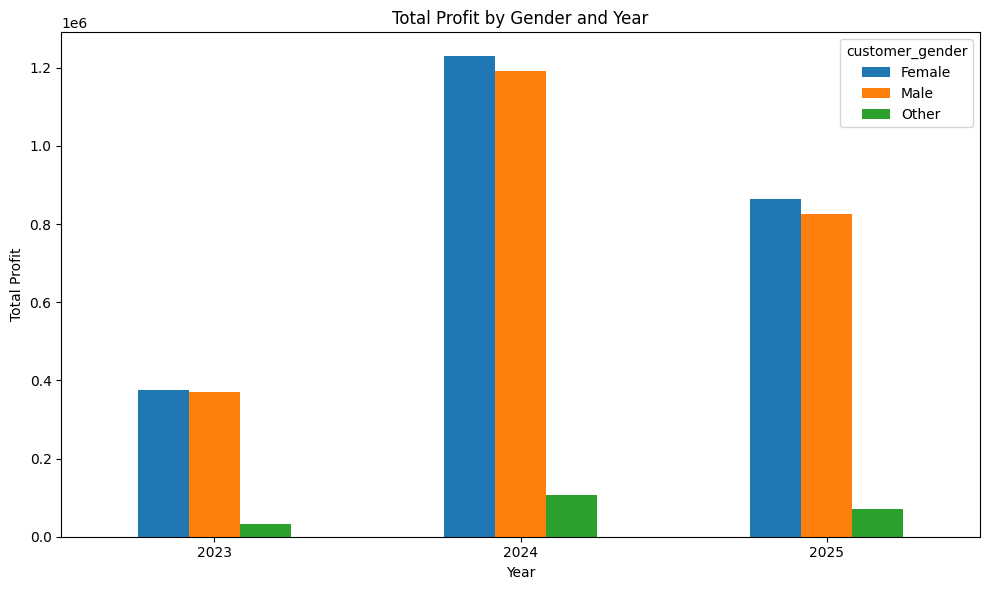

In [ ]:
# --- Phase 6: Analytics (Sales Data Mart) ---

print("\n[Phase 6] Running BI analytics on 'Sales Data Mart'...")

# Query: Total profit by customer gender and year
query1 = """
    SELECT
        t2.Year,
        t3.customer_gender,
        SUM(t1.profit_margin) AS TotalProfit
    FROM
        FactSales AS t1
    JOIN
        DimDate AS t2 ON t1.DateKey = t2.DateKey
    JOIN
        DimCustomer AS t3 ON t1.CustomerKey = t3.CustomerKey
    GROUP BY
        t2.Year, t3.customer_gender
    ORDER BY
        t2.Year, TotalProfit DESC
"""
try:
    report_df_1 = pd.read_sql_query(query1, conn)
    print("\n--- BI Report: Total Profit by Gender & Year ---")
    print(report_df_1)

    # Visualize
    report_df_1.pivot_table(
        index='Year',
        columns='customer_gender',
        values='TotalProfit'
    ).plot(kind='bar', figsize=(10, 6))

    plt.title('Total Profit by Gender and Year')
    plt.ylabel('Total Profit')
    plt.xlabel('Year')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error during analytics: {e}")


[Phase 6] Running BI analytics on 'Product Data Mart'...

--- BI Report: Avg Rating & Stock by API Category ---
           CategoryName  AverageRating  TotalStock
0   kitchen-accessories       3.820667        1656
1             groceries       3.911481        1417
2                beauty       3.748000         392
3          mens-watches       3.660000         349
4           mens-shirts       3.180000         307
5            fragrances       3.826000         280
6               laptops       3.622000         258
7             furniture       4.006000         245
8       home-decoration       3.784000         220
9            mens-shoes       4.602000         188
10   mobile-accessories       4.570000         128


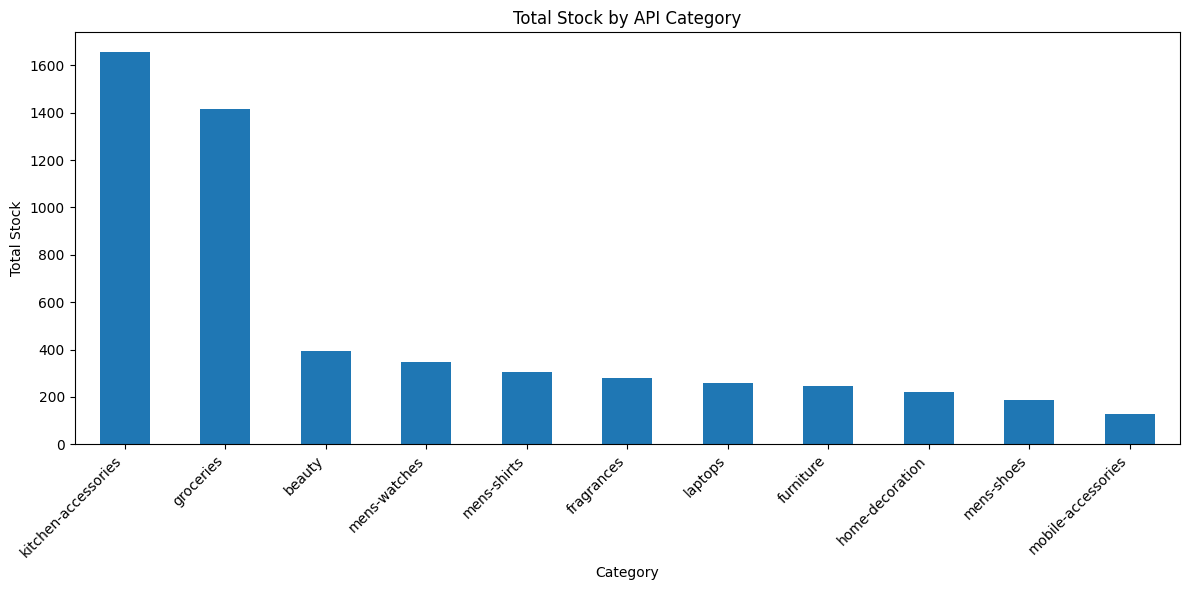

In [ ]:
# --- Phase 6: Analytics (Product Data Mart) ---

print("\n[Phase 6] Running BI analytics on 'Product Data Mart'...")

# Query: Average rating and total stock by API category
query2 = """
    SELECT
        t2.CategoryName,
        AVG(t1.rating) AS AverageRating,
        SUM(t1.stock) AS TotalStock
    FROM
        FactProductStats AS t1
    JOIN
        DimCategory_API AS t2 ON t1.CategoryKey = t2.CategoryKey
    GROUP BY
        t2.CategoryName
    ORDER BY
        TotalStock DESC
"""
try:
    report_df_2 = pd.read_sql_query(query2, conn)
    print("\n--- BI Report: Avg Rating & Stock by API Category ---")
    print(report_df_2)

    # Visualize
    report_df_2.set_index('CategoryName')['TotalStock'].plot(
        kind='bar',
        figsize=(12, 6),
        title='Total Stock by API Category'
    )
    plt.ylabel('Total Stock')
    plt.xlabel('Category')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error during analytics: {e}")



[Phase 6 - ML] Applying ML (RFM Clustering) to find customer segments...

--- Customer Segment Analysis (Averages) ---
            Recency  Frequency  MonetaryValue
Segment                                      
0        204.859078   3.231252     286.432690
1        140.787871   6.093942    1237.772088
2         19.353089   6.334807    1042.352436


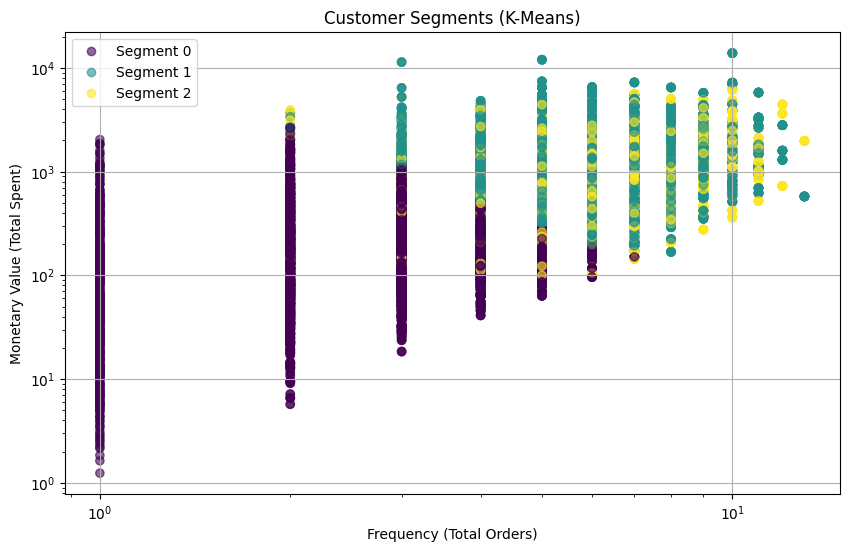

In [ ]:
# --- Phase 6 (cont.): Analytical Application (ML) ---

print("\n[Phase 6 - ML] Applying ML (RFM Clustering) to find customer segments...")

# We need Recency, Frequency, and Monetary value for each customer
# R = Days since last purchase
# F = Total number of orders
# M = Total money spent
rfm_query = """
    SELECT
        t1.CustomerKey,
        MAX(t2.Date) AS LastPurchaseDate,
        COUNT(DISTINCT t1.order_id) AS Frequency,
        SUM(t1.total_amount) AS MonetaryValue
    FROM
        FactSales AS t1
    JOIN
        DimDate AS t2 ON t1.DateKey = t2.DateKey
    GROUP BY
        t1.CustomerKey
"""

try:
    rfm_df = pd.read_sql_query(rfm_query, conn)

    # Calculate Recency
    rfm_df['LastPurchaseDate'] = pd.to_datetime(rfm_df['LastPurchaseDate'])
    snapshot_date = rfm_df['LastPurchaseDate'].max() + pd.Timedelta(days=1)
    rfm_df['Recency'] = (snapshot_date - rfm_df['LastPurchaseDate']).dt.days

    # Prepare data for K-Means
    # We remove outliers and log-transform/scale for better clustering
    rfm_ml = rfm_df[['Recency', 'Frequency', 'MonetaryValue']]
    rfm_ml = rfm_ml[rfm_ml['MonetaryValue'] > 0] # Remove non-spenders

    # Log transform to handle skew
    rfm_log = np.log1p(rfm_ml)

    # Scale data
    scaler = StandardScaler()
    rfm_scaled = scaler.fit_transform(rfm_log)

    # Apply K-Means clustering
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
    rfm_df['Segment'] = kmeans.fit_predict(rfm_scaled)

    print("\n--- Customer Segment Analysis (Averages) ---")
    print(rfm_df.groupby('Segment')[['Recency', 'Frequency', 'MonetaryValue']].mean())

    # Plot the customer segments
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        rfm_df['Frequency'],
        rfm_df['MonetaryValue'],
        c=rfm_df['Segment'],
        cmap='viridis',
        alpha=0.6
    )
    plt.title('Customer Segments (K-Means)')
    plt.xlabel('Frequency (Total Orders)')
    plt.ylabel('Monetary Value (Total Spent)')
    plt.xscale('log') # Use log scale for better visualization
    plt.yscale('log')
    plt.legend(handles=scatter.legend_elements()[0], labels=['Segment 0', 'Segment 1', 'Segment 2'])
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error during ML analytics: {e}")

In [ ]:
# --- Final: Clean up ---
try:
    conn.close()
    print("\n--- DWH Project Simulation Complete. Connection closed. ---")
except Exception as e:
    print(f"Could not close connection: {e}")


--- DWH Project Simulation Complete. Connection closed. ---


Convert .db to .sql



In [ ]:
# import sqlite3

# # Path to your SQLite .db file (in Colab)
# db_path = '/content/project_data_warehouse.db'  # 👈 change this to your file name
# output_sql = '/content/output_sqlserver.sql'

# # Connect to the SQLite database
# conn = sqlite3.connect(db_path)
# with open(output_sql, 'w', encoding='utf-8') as f:
#     for line in conn.iterdump():
#         f.write('%s\n' % line)
# conn.close()

# print(f"✅ Conversion complete! SQL dump saved at: {output_sql}")


✅ Conversion complete! SQL dump saved at: /content/output_sqlserver.sql


In [ ]:
import sqlite3
import os

# --- Configuration ---
# Your main database file (the one you created)
source_db_file = 'project_data_warehouse.db'

# The name you want for the backup file
backup_file = 'project_data_warehouse.bak'
# ---

print(f"Starting backup of '{source_db_file}' to '{backup_file}'...")

# Check if the source file exists
if not os.path.exists(source_db_file):
    print(f"Error: Source file not found: {source_db_file}")
    print("Please make sure the file is in the same directory.")
else:
    source_conn = None
    dest_conn = None

    try:
        # 1. Connect to the source database (the .db file)
        source_conn = sqlite3.connect(source_db_file)

        # 2. Connect to the destination database (the .bak file)
        # This command will create the .bak file if it doesn't exist
        dest_conn = sqlite3.connect(backup_file)

        # 3. Use the online backup API
        print("  - Connections established. Starting backup process...")
        with dest_conn:
            source_conn.backup(dest_conn)

        print(f"  - Backup successful!")
        print(f"  - File created: {backup_file} (Size: {os.path.getsize(backup_file)} bytes)")

    except sqlite3.Error as e:
        print(f"An SQLite error occurred: {e}")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    finally:
        # 4. Close both connections
        if dest_conn:
            dest_conn.close()
        if source_conn:
            source_conn.close()

    print("\n--- Backup Script Finished ---")

Starting backup of 'project_data_warehouse.db' to 'project_data_warehouse.bak'...
  - Connections established. Starting backup process...
  - Backup successful!
  - File created: project_data_warehouse.bak (Size: 17350656 bytes)

--- Backup Script Finished ---


In [ ]:
%pip install pyodbc
import sqlite3
import pandas as pd
import pyodbc
from sqlalchemy import create_engine
import urllib
import os

# --- 1. SQL Server Connection Details (Configure this!) ---
# e.g., 'localhost', '.\SQLEXPRESS', or a cloud endpoint
SERVER = 'IJJO'
# The database to create and load data into
DATABASE = 'prime2'
# e.g., 'SA'
USERNAME = 'IJJO\ijjob'
PASSWORD = 'ezaan046'
DRIVER = '{ODBC Driver 17 for SQL Server}'

# --- 2. SQLite Database File ---
sqlite_db_file = 'project_data_warehouse.db'

# --- 3. Create Database if it Doesn't Exist ---
# This part connects to the 'master' database to create your new DB
try:
    master_conn_str = f'DRIVER={DRIVER};SERVER={SERVER};DATABASE=master;UID={USERNAME};PWD={PASSWORD}'
    master_conn = pyodbc.connect(master_conn_str, autocommit=True)
    master_cursor = master_conn.cursor()
    master_cursor.execute(f"IF NOT EXISTS(SELECT * FROM sys.databases WHERE name='{DATABASE}') EXEC('CREATE DATABASE {DATABASE}')")
    print(f"Database '{DATABASE}' is ready.")
    master_cursor.close()
    master_conn.close()
except pyodbc.Error as ex:
    print(f"ERROR: Could not connect to 'master' or create database. Check credentials/driver.")
    print(ex)
    exit() # Stop if we can't create the DB

# --- 4. ETL Script using SQLAlchemy and CHUNKING ---
try:
    # A. Connect to the SQLite source database
    sqlite_conn = sqlite3.connect(sqlite_db_file)
    print(f"Connected to SQLite source: {sqlite_db_file}")

    # B. Connect to the SQL Server destination using SQLAlchemy (for high speed)
    safe_password = urllib.parse.quote_plus(PASSWORD)
    engine_str = f'mssql+pyodbc://{USERNAME}:{safe_password}@{SERVER}/{DATABASE}?driver={DRIVER.replace(" ", "+")}'
    sql_server_engine = create_engine(engine_str, fast_executemany=True)
    print(f"Connected to SQL Server destination: {DATABASE}")

    # C. Get list of all tables from SQLite
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", sqlite_conn)['name'].tolist()

    # D. Iterate through tables and load them IN CHUNKS to save memory
    for table_name in tables:
        print(f"\nProcessing table: {table_name}...")

        # How many rows to read at a time (e.g., 50,000)
        # You can make this smaller (like 10000) if it still crashes
        chunk_size = 50000

        # Create an iterator that reads the table in chunks
        chunk_iterator = pd.read_sql_query(
            f"SELECT * FROM {table_name}",
            sqlite_conn,
            chunksize=chunk_size
        )

        is_first_chunk = True

        # Loop over each chunk
        for i, chunk_df in enumerate(chunk_iterator):
            print(f"  - Processing chunk {i+1} ({len(chunk_df)} rows)...")

            if is_first_chunk:
                # First chunk: create the table (if_exists='replace')
                chunk_df.to_sql(table_name,
                                sql_server_engine,
                                if_exists='replace',
                                index=False,
                                chunksize=1000) # chunksize for writing
                is_first_chunk = False
            else:
                # Subsequent chunks: append to the table
                chunk_df.to_sql(table_name,
                                sql_server_engine,
                                if_exists='append',
                                index=False,
                                chunksize=1000) # chunksize for writing

        print(f"  - Finished importing table {table_name}.")

    # E. Close connections
    sql_server_engine.dispose()
    sqlite_conn.close()
    print("\n--- Data Migration Complete ---")

except pyodbc.Error as ex:
    sqlstate = ex.args[0]
    if 'Login failed' in str(ex):
        print(f"ERROR: SQL Server Login Failed. Check credentials and server name.")
    else:
        print(f"An error occurred during SQL Server operation: {ex}")
except sqlite3.Error as ex:
    print(f"An error occurred during SQLite operation: {ex}")
except Exception as ex:
    print(f"An unexpected error occurred: {ex}")

<>:15: SyntaxWarning: invalid escape sequence '\i'
<>:15: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-149551088.py:15: SyntaxWarning: invalid escape sequence '\i'
  USERNAME = 'IJJO\ijjob'


ERROR: Could not connect to 'master' or create database. Check credentials/driver.
('01000', "[01000] [unixODBC][Driver Manager]Can't open lib 'ODBC Driver 17 for SQL Server' : file not found (0) (SQLDriverConnect)")
Connected to SQLite source: project_data_warehouse.db
Connected to SQL Server destination: prime2

Processing table: DimCustomer...
  - Processing chunk 1 (33877 rows)...
An unexpected error occurred: (pyodbc.Error) ('01000', "[01000] [unixODBC][Driver Manager]Can't open lib '{{ODBC Driver 17 for SQL Server}};Server=IJJO;Database=prime2;UID=IJJO\\ijjob;PWD=ezaan046' : file not found (0) (SQLDriverConnect)")
(Background on this error at: https://sqlalche.me/e/20/dbapi)
